## Investigating optical cavity with different geometries
Alina Soflau, Andreas Freise, 06.01.2026

This notebook explores optical cavity geometries using FINESSE. Fabry-Perot, triangular and bow-tie configurations are modelled. Cavities are a fundamental building block of current gravitational wave detectors and an important instrument in laser optics. 

After completing this notebook, you will be able to:

* Build and simulate different cavity and interferometer geometries in FINESSE
* Perform parameter scans to study the cavity behaviour on resonance
* Determine cavity parameters such as free spectral range, linewidth, and finesse
* Relate these parameters to cavity geometry and mirror properties 

### What you will submit

The notebook activities are your “experiments”. The output expected from you is a short report (between 2000 and 4000 words) based on the results obtained in this notebook, in which you describe and interpret what you have learned. 

In the report, you should describe and discuss the physics of the simulated optical cavities: which cavity configurations were modelled (Fabry–Perot LIGO/ET-inspired examples, triangular and bow-tie) and why the different geometries are relevant; what parameters were scanned (e.g. mirror tuning and laser frequency), and why. You should focus on discussing the physics properties optical cavities and how these are used to enhance or enable other optical experiments. Refer to the physical shape of the cavity as well as the cavity parameters such as linewidth, finesse and free spectral range.

----

### Background 

Current interferometric gravitational wave detectors on the Earth are amongst the most precise instruments for measuring length changes. Their L-shaped design directly reflects the transverse nature of gravitational perturbations, which stretch space in one direction and compress it perpendicularly, both orthogonal to the direction of propagation.  

If a gravitational wave passes the detector, one arm of the interferometer is alternately stretched and compressed, and this pattern repeats in time (stretch–compress–stretch-...). Simultaneously, the perpendicular arm experiences the opposite deformation: when one arm is stretched, the other is compressed. The two arms oscillate out of phase. 

### Optical cavities 

In an interferometer, there are many optical resonators, also called optical cavities or just cavities. The cavities often have different geometries and have different specific purposes. Below we choose three different types of cavities, used in both current and future GW detectors: 
 
- Fabry-Perot cavity. A Fabry-Perot cavity consists of two mirrors separated by a distance L. The two mirrors are typically highly reflective, implying that only a tiny part of the incident light is transmitted and enters the cavity. This tiny amount of light then propagates back and forth between the mirrors. If, after one round trip, the returning field has the same phase as the newly entering field, constructive interference occurs and the circulating field builds up inside the cavity. This condition is known as $\textit{resonance}$, which again, arises from interference between the incoming field and the field already circulating inside the cavity. 

- Triangular cavity. In a triangular cavity, three mirrors are arranged to form a closed triangular path. Light enters the cavity through one of the mirrors and then propagates around the triangle, and the concept of resonance is the same as for the FP cavity. 

- Bow-tie cavity. A bow-tie cavity is a ring cavity formed by four mirrors, arranged so that the optical path crosses itself, giving rise to the characteristic bow-tie shape. 


In [ ]:
# install pypi wheel only on google colab
!env | grep -q 'colab' && pip install finesse || echo 'Not on google colab, assuming finesse already installed'

In [1]:
import finesse 
import matplotlib.pyplot as plt
import numpy as np
#finesse.show_tracebacks(True)
finesse.configure(plotting=True)
from finesse.analysis.actions import Xaxis, Maximize

##  LIGO Fabry-Perot arm-cavity in the plane wave approximation

Below, we adopt parameters inspired by the Advanced LIGO arm cavities. Source: https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html

Our model is simplified, since the cavity is lossless and is made by two flat mirrors (labeled as $\text{m}_1$ and $\text{m}_2$), within which a plane-wave optical field circulates. 

In many simulations the shape of the light beams or, in general, the geometric properties of a beam transverse to the optical axis are not of primary interest. In that case one can discard this information and restrict the model to the field on the optical axis. This is equivalent to a model where all light fields are plane waves traveling along one optical axis. This is the standard mode of Finesse and is called plane-wave approximation. 

### Developing an intuitive understanding of the resonance in a Fabry-Perot cavity. 

A cavity resonates when the round-trip phase accumulated by the optical field satisfies $ 2k D= 2\pi m$, $m \in \mathbb{Z}$. Resonance can be achieved either by introducing a microscopic tuning of the mirrors or by sweeping the laser frequency. In the following cells, we practically sweep over many cavity resonances using both approaches, and we examine the circulating, reflected, and transmitted powers.

In [2]:
# X arm LIGO parameters from https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html

# This will be our reference model during the tasks 1,2,3,4
ifo0 = finesse.Model()

ifo0.parse(f"""
# Laser source with unit input power
l l1 P=1
           
# Space between the laser and the input mirror, by default is 0 m. 
s s1 l1.p1 m1.p1

# Input mirror of the cavity
# T is the power transmissivity, L is the loss 
# Finesse will compute the power reflectivity as R=1-T-L
m m1 T=0.0148 L=37.5e-6
           
# Space between the two cavity mirrors (cavity length)
# This defines the macroscopic cavity length L = 4 km
s s2 m1.p2 m2.p1 L=3994.485

# End mirror of the cavity 
m m2 T=7.1e-6 L=37.5e-6
""");

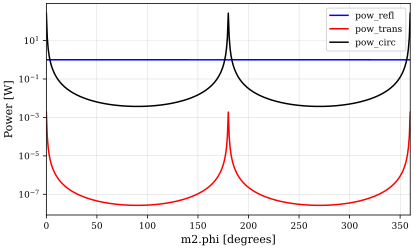

Power : 265.327 W at m2.phi=0.000000 deg


In [ ]:
# Make a 'deep' (i.e. complete with internal structures) copy of the above defined model 
ifo1 = ifo0.deepcopy()

# Parsing in additional components: three photodetectors
# - pow_refl: reflected power at the input mirror
# - pow_trans: transmitted power at the end mirror
# - pow_circ: circulating power inside the cavity
ifo1.parse("""
pd pow_refl m1.p1.o
pd pow_trans m2.p2.o
pd pow_circ m2.p1.i 
 """)

# Run the FINESSE model ifo1, sweeping the parameter m2.phi linearly from 0 
# to 360 (degrees) using 400 points, and store the result in out0. 
# A sweep from 0 to 360 degrees corresponds to a cavity length change of one 
# wavelength (λ), i.e. two cavity resonances (since resonances occur every λ/2).
out1 = ifo1.run(Xaxis('m2.phi', 'lin', 0, 2*180, 400))

# Plot the circulating, reflected, and transmitted powers
out1.plot(logy=True)

# We use the 'Maximize' FINESSE action to find the value of m2.phi (the tuning of 
# mirror m2) for which the circulating power in the interferometer is maximum.
# In other words, we are asking: at what mirror phase does the detector store the 
# most optical power? 
sol = ifo1.run(Maximize(ifo1.pow_circ, # "circulating power" detector
        parameter=ifo1.m2.phi,        # parameter to optimize 
        method="Nelder-Mead",
        fatol=1e-4,
        adaptive=True,
    )
)

print(f"Power : {-sol.result.fun:.6g} W at m2.phi={sol.result.x[0]:.6f} deg")

**Task**: Look at the absolute values of the three powers and how they are related to each other. Can you explain the relationship with simple and intuitive arguments? 

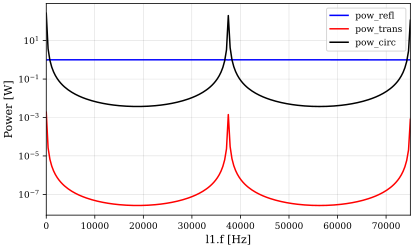

In [4]:
# We should get a similar result if we keep the mirrors in position
# but sweep the laser frequency instead.

# For a linear Fabry–Perot cavity of length L = 4000 m, the free spectral range is:
# FSR = c / (2L) = 37.5 kHz 
# Adjacent cavity resonances are separated by one FSR.
# Sweeping the laser frequency over 2*FSR therefore moves the cavity through 
# two successive resonances.
out2 = ifo1.run(Xaxis('l1.f', 'lin', 0, 2*37.5e3, 200))

# Plot the circulating, reflected, and transmitted powers
out2.plot(logy=True);

### The cavity linewidth 

For a cavity the linewidth is commonly defined as the Full Width at Half Maximum (FWHM) of the resonance peak, which we use here. But other definitions are also used, for example the Half Width at Half Maximum (HWHM) and the pole frequency $f_p$​, which both are equal to half the FWHM. The linewidth tells us how large the frequency band is that is resonant inside the cavity, thus, how well the cavity filters out other frequencies.

Mathematically we have:

$$ \text{FWHM} = f_1 - f_2
$$

where $f_1$ and $f_2$ are such that

$$ P(f_1)=P(f_2)= \dfrac{P_{\text{max}}}{2}
$$

Is proofed elsewhere (see Living Review, Freise et al.) that the exact formula for FWHM is:

$$  \text{FWHM}= \dfrac{2 \text{FSR}}{\pi} \arcsin \bigg(\dfrac{1-r_1 r_2}{2 \sqrt{r_1 r_2}} \bigg) \simeq 0.09 \text{kHz}.
$$


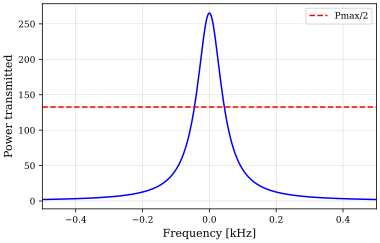

Frequencies : -45.0, 45.0 Hz
FWHM : 90.0 Hz


In [ ]:
ifo_FWHM = ifo0.deepcopy()

ifo_FWHM.parse(" pd pow_circ m2.p1.i ")

# We zoom near one resonance 
sol_FWHM = ifo_FWHM.run(Xaxis('l1.f', 'lin', -0.5e3, 0.5e3, 400))

x = sol_FWHM.x1
y = sol_FWHM['pow_circ']

# Finding the maximum power (how much, and at which frequency)
Pmax = y.max()
half = Pmax / 2
imax = y.argmax()

plt.plot(x/1e3, y)
plt.axhline(half, color='r', ls='--', label='Pmax/2')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Power transmitted')
plt.legend()
plt.show()


**Task**: Find a simple way to measure the linewidth using the output from the simulation above.

In [ ]:
#left = ...
#right = ... 
#print(f"Frequencies : {left:.3}, {right:.3} Hz")
#print(f"FWHM : {(right-left):.3} Hz")

### Computing the finesse $\mathcal{F}$. 

The ratio of the free spectral range to the linewidth is called the finesse $\mathcal{F}$ of the cavity: 

$$ \mathcal{F}= \dfrac{ \text{FSR}}{\text{FWHM}}= \dfrac{\pi}{2 \arcsin \bigg(\dfrac{1-r_1 r_2}{2 \sqrt{r_1 r_2}} \bigg)} \simeq 420 
$$ 


So far, from theory, using the mirror parameters and the arm length, we computed: FSR; FWHM; $\mathcal{F}$. 

To confirm our results, we can define explicitly the cavity in the model, and then FINESSE can compute its internal properties, such as FSR, FWHM and $\mathcal{F}$. 

In [6]:
ifo_cav = ifo0.deepcopy()

# We explicitly define the Fabry–Perot cavity in the model.
# This tells FINESSE that the optical path starting at the output port of m1 (m1.p2.o),
# propagating to the input port of m2 (m2.p1.i), and back again,
# should be treated as a single physical cavity.
# Defining the cavity is required for FINESSE to compute cavity properties
# such as FSR, finesse, and linewidth. 
ifo_cav.parse("cav acav m1.p2.o m2.p1.i")

# Print the internally computed cavity information.
print(ifo_cav.acav.info())

Cavity acav

Parameters:
n/a

Information:
┌───────────────────────┬──────────────────────┐
│ Description           │ Value                │
╞═══════════════════════╪══════════════════════╡
│ FSR                   │ 37525.79594115386    │
├───────────────────────┼──────────────────────┤
│ Loss                  │ 0.014881438247499879 │
├───────────────────────┼──────────────────────┤
│ Finesse               │ 419.0658427911947    │
├───────────────────────┼──────────────────────┤
│ FWHM                  │ 89.54630062715849    │
├───────────────────────┼──────────────────────┤
│ Storage time          │ 0.003554696106421291 │
├───────────────────────┼──────────────────────┤
│ Pole                  │ 44.773150313579244   │
├───────────────────────┼──────────────────────┤
│ Round trip length     │ 7988.97              │
├───────────────────────┼──────────────────────┤
│ Waist size            │ [nan nan]            │
├───────────────────────┼──────────────────────┤
│ Waist position        │ 

/Users/adf/git/simulation/finesse3/src/finesse/components/cavity.py:1017: UserWarning: the signs of the radii of curvature of mirrors 'm2' and 'm1' in the unstable Fabry-Perot cavity 'acav' are equal
  warn(
/Users/adf/git/simulation/finesse3/src/finesse/model.py:2136: CavityUnstableWarning: cavity 'acav' added to the model is unstable
  warn(


## Einstein Telescope (ET) Fabry-Perot arm cavity: beyond the plane wave approximation


The Einstein Telescope (ET) is a future European observatory for gravitational waves, designed to be at least 10 times more sensitive than current interferometers.  ET includes two configurations: the Low-Frequency (ET-LF) variant, optimized for low-frequency detection and operating at 10 K, and the High-Frequency (ET-HF) variant, that targets high frequency GWs and operating at 290 K. Details of these configurations are provided in (Einstein Telescope Design Report Update, 2020). In both configurations, Fabry-Perot arm cavities are significantly longer, 10-15 km depending on the final design choice. 

In the previous LIGO example, we modeled the arm cavity without mirror curvature and treated the optical field as a plane wave. This was done on purpose, as a didactic simplification. That model was sufficient to introduce and compute longitudinal cavity properties such as the FSR, linewidth, and finesse, which do not depend on the transverse shape of the beam. 

In reality, neither LIGO nor ET cavities support plane waves. The field inside the arms always has a Gaussian tranverse profile, and the mirrors have a finite radius of curvature chosen to match the beam wavefronts.  


Below, with respect to the previous LIGO example, we have:
- ET cavity parameters, that can be found in Einstein Telescope Design Report Update, 2020. 
-  a Gaussian beam and mirror curvature to illustrate how a more realistic cavity model looks and how transverse beam geometry is incorporated. The values of FSR, finesse, and linewidth derived in absence of RoC remain valid because these quantities do not depend on the mirror curvature or on the beam shape.

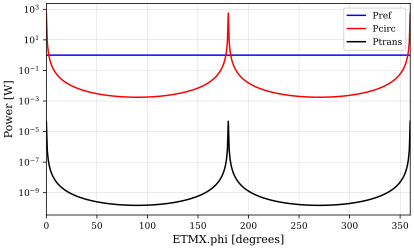

Cavity XARM

Parameters:
n/a

Information:
┌───────────────────────┬───────────────────────────────┐
│ Description           │ Value                         │
╞═══════════════════════╪═══════════════════════════════╡
│ FSR                   │ 14989.6229                    │
├───────────────────────┼───────────────────────────────┤
│ Loss                  │ 0.007080693868749988          │
├───────────────────────┼───────────────────────────────┤
│ Finesse               │ 884.222807777051              │
├───────────────────────┼───────────────────────────────┤
│ FWHM                  │ 16.952314244962906            │
├───────────────────────┼───────────────────────────────┤
│ Storage time          │ 0.018776780655677797          │
├───────────────────────┼───────────────────────────────┤
│ Pole                  │ 8.476157122481453             │
├───────────────────────┼───────────────────────────────┤
│ Round trip length     │ 20000.0                       │
├───────────────────────┼────

In [7]:
# ET-HF X-arm model

# In order to add the beam and cavity geometry we have to
# provide additional parameters to the mirrors:
# - RoC: radius of curvature of the mirror surface (a flat mirror has an 
# infinite radius of curvature). 
# And we have to specify the shape of the input laser via the
# beam waist size (w0) and position (z).

ifo_ET = finesse.Model()
ifo_ET.parse(f"""
l L0 P=1
gauss g1 ETMX.p2.i w0=0.0142 z=5e3
s LITM L0.p1 ITMX.p1
m ITMX T=7000e-6 L=37.5e-6 Rc=-5070.892
s LX ITMX.p2 ETMX.p1 L=10000
m ETMX T=6e-6 L=37.5e-6 Rc=5070.892

# Cavity definition is required for FINESSE to compute cavity properties! 
# FINESSE does not automatically identify optical cavities,
# because in a realistic interferometer a single mirror can belong to multiple cavities simultaneously. 
# Only if the user explicitly specifies the sequence of optical components that defines a given cavity, 
# FINESSE can associate a unique round-trip path with that cavity and compute its properties. 
cav XARM ITMX.p2.o ETMX.p1.i

# Photodetectors
pd Pref  ITMX.p1.o     
pd Pcirc ITMX.p2.o     
pd Ptrans ETMX.p2.o
""")

# This causes Finesse to use only the lowest order Hermite-Gauss mode to
# compute the laser beam propagation.
ifo_ET.modes(maxtem=0)

out_ET = ifo_ET.run(Xaxis('ETMX.phi', 'lin', 0, 2*180, 400))
out_ET.plot(logy=True)

print(ifo_ET.XARM.info())

In the above table, we see other quantities related to cavity geometry, as:

1. The storage time, that for simplicity we denote as $\tau$, which is the average time a photon remains inside the cavity before escaping. More specifically, the storage time represents how long the optical field remains stored in the cavity before decaying to 1/e of its original value. We can compute the average number of round trips a photon makes before escaping, as:


$$  N= \dfrac{ \text{ time spent inside}}{\text{time per round trip }}= \dfrac{ \tau_c}{ L/c}=\dfrac{ \tau_c \cdot c }{L}
$$

where

$$ \tau_c = \dfrac{1}{\text{FWHM} \cdot \pi}
$$ 

2. The pole, or more specifically, the frequency pole, $f_p$, is the frequency associated with the storage time $\tau$:

$$ f_p= \dfrac{ 1}{2 \pi \tau}
$$ 

### We can compare FSR, FWHM and $\mathcal{F}$ for LIGO and ET:

- $\mathcal{F}\simeq 884$ for ET, compared to $\mathcal{F} \simeq 420$ for LIGO. 
- FWHM $\simeq$ 17 kHz for ET, smaller compared to FWHM $\simeq$ 90 kHz for LIGO.
- FSR $\simeq$ 15.0 kHz for ET (10 km arm length), compared to FSR $\simeq$ 37.5 kHz for LIGO. 


**Task:** The cavity parameters have a direct and visible impact on the resonance structure.
Make plot comparing the resonance peaks of the LIGO and ET arm cavities. Think about whether these differences have an impact on the detector and why.

# Triangular cavity model 

Below, we construct with a triangular cavity, formed by three mirrors (denoted MC1, MC2, and MC3) and three optical paths between them (L12, L13, L23). 

 In LIGO, a triangular cavity of this type is placed immediately after the laser, and is known as the Input Mode Cleaner (IMC).Its purpose is to clean and stabilize the laser beam before it enters the main interferometer. For example, the laser’s optical frequency is not perfectly constant in time, but oscillates slightly around its nominal, central value; the IMC acts as a frequency filter reducing laser's noise before it enters the main interferometer. 
 
 The Einstein Telescope Design Report Update, 2020 considers for ET two IMCs in series, but the role is the same. 


### Note on Finesse

A mirror component has only two ports. That means we can only connect one incoming and one outgoing beam, which is perfect for a linear cavity, in which light bounces back and forth between the two mirrors. To model a triangular cavity in Finesse, we use beam splitter components, because they provide multiple ports (p1,p2,p3,p4, oriented clockwise), allowing us to connect the optical paths properly and close the cavity loop.

In [9]:
# from https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html 

# T1_imc, L1_imc = 6150e-6, 20e-6
# T2_imc, L2_imc = 3.5e-6, 20e-6 
# T3_imc, L3_imc = 6130e-6, 20e-6 

# R1_imc = 1 - T1_imc - L1_imc
# R2_imc = 1 - T2_imc - L2_imc
# R3_imc = 1 - T3_imc - L3_imc

IMC_losses = finesse.Model()
IMC_losses.parse(f""" 
l LI P=125

# -------- IMC mirrors --------
# L = 20 ppm on all three; R = 1 - T - L  
# Light transmitted through MC1 (from p1 to p3) enters MC3 (through p1, then reflected through p2), 
# then goes into MC2 (enters in p1, reflected in p2).
# Finally returns from MC2.p2 into MC1.p4, which reflects into MC1.p3, closing the triangular cavity. 
               
bs MC1  T=6150e-6 L=20e-6 Rc=101609 
bs MC2  T=3.5e-6  L=20e-6 Rc=27.178 
bs MC3  T=6130e-6 L=20e-6 Rc=171747 

# --- Connect spaces to form a triangle  ---
s L_MC1   LI.p1     MC1.p1      L=0
s MC1_MC3 MC1.p3    MC3.p1      L=0.465      
s MC3_MC2 MC3.p2    MC2.p1      L=16.24057   
s MC2_MC1 MC2.p2    MC1.p4      L=16.24057 
#cav IMC MC2.p2.o  
nothing test
s MC3_test MC3.p3 test.p1 
""");



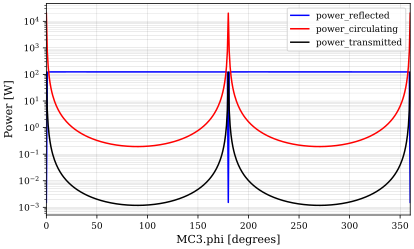

In [10]:
IMC_losses1 = IMC_losses.deepcopy()
IMC_losses1.parse("""
pd power_reflected MC1.p2.o
pd power_circulating MC1.p3.o
pd power_transmitted MC3.p3.o
""")

sol_IMC_1 = IMC_losses1.run(Xaxis('MC3.phi', 'lin', 0,360 ,400))
sol_IMC_1.plot(logy= True);

The concept of optical resonance is the same for all cavity geometries. The specific geometry determines the optical path taken by the light, but in all presented examples, resonance arises from constructive interference of the optical field after one complete round trip. 

**Task:** Find out from literature of colleagues why or when a triangle cavity can be a better instrument than a linear cavity. Refer to a real example and explain which feature of the triangular cavity is used.

## The cavity as a composite mirror

A cavity can be seen as an optical component similar to a mirror component, i.e. it is an object that partially reflects and partially transmits an injected light beam. The amount of the power reflected and transmitted is not fixed but can be adjusted via the tuning of the cavity, which is easy to do in an experiment. Thus, a cavity can be used as a 'tuneable' mirror.

**Task**: Make an example of a cavity as a tuneable mirror and show the power reflectivity and transmission you can reach by changing the resonance condition (e.g. by changing the tuning of one mirror 'phi').

## Coupled cavities: the Power Recycling Cavity (PRC) and Signal Recycling Cavity (SRC) 

The 'recycling cavities' in LIGO or the Einstein Telescope are three-mirror linear cavities, in which the third mirror (recycling mirror) is used to modify the performance of the two-mirror cavity (arm cavity). This is an advanced example on how complex cavity constructions are used to improve the behaviour of gravitational wave detectors over the so-called 'simple Michelson'.

To understand the below code, we need two ingredients:

1. The Michelson interferometer equipped with a Fabry-Perot cavity in each arm is not enough to detect gravitational waves. 

2. The laser field entering the interferometer is a single-frequency optical field: $E_{\text{in}}=E_0 e^{i \omega_0 t}$, where with $\omega_0$ we denote the laser's frequency. This laser field is known as the CARRIER field. 

Now, a gravitational wave causes a differential arm length change:

$$ \delta L(t)= \delta L_0 \cos (\Omega t) 
$$

which produces a phase modulation of the carrier:

$$ E(t) = E_0 e^{i \omega t} e^{i k \delta L(t)} 
$$ 

Assuming $k \delta L(t) \ll 1$, we can Taylor expand, obtaining:

$$ E(t)= E_0 e^{i \omega_0 t} \bigg[1+\dfrac{i k \delta L_0}{2} e^{i \Omega t} + \dfrac{i k \delta L_0}{2} e^{-i \Omega t}  \bigg]
$$ 

This Eq. shows three frequencies: the carrier, whose frequency is again $\omega_0$, and two sidebands, at frequencies $+\Omega$ and $-\Omega$, which carry the GW signal. A GW has $\Omega \simeq 10^1-10^3$ Hz, while $\omega_0$ is $\simeq 10^{14}$ Hz. 

### Power Recycling Cavity acts on the carrier and narrows the bandwidth 
The interferometer is operated close to a dark fringe, so most of the carrier light is reflected back toward the laser. By introducing an additional mirror between the laser and the beam splitter, known as Power Recycling Mirror (PRM), we have an additional cavity, the Power Recycling Cavity (PRC), formed by the PRM and the whole interferometer. The PRM allows for increased circulating power, without the need to boost the input power. This technique, known as power recycling, effectively "recycles" light that would otherwise be lost. The band of the PRC must be very narrow because the only aim is to increase the circulating power, but circulating light is strictly required to have frequency $\omega_0$. 


### SRC acts on the GW sidebands and broadens the bandwidth
The sidebands, in principle, exit the interferometer at the dark port and leave the detector after a single interaction with the arms; this limits the signal strength. That's why, a second mirror is placed at the output (dark) port: the Signal Recycling Mirror (SRM). Together with the interferometer, it forms the Signal Recycling Cavity (SRC), which reflects the GW sidebands back into the interferometer, allowing them to interact multiple times with the arm cavities. The SRC does not aim to enhance a single frequency (as the PRC), but it must enhance a range of sideband frequencies that are astrophysically relevant GWs: $\Omega \simeq 10^1-10^3$ Hz. 


### Key point

The carrier and the GW sidebands play different physical roles, so they benefit from different optical resonances. This is the fundamental reason why multiple cavities are used. Both cases can be studied by using a simpler example in which the 'main interferometer' is represented as a single two-mirror cavity, and the whole system is then mimicked by a three-mirror cavity.

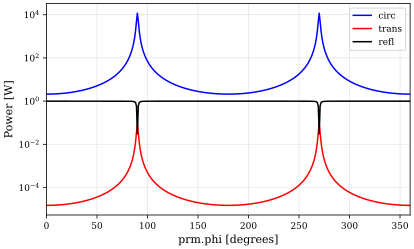

Power : 11782.2 W at srm.phi=90.000036 deg


In [12]:
# from https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html 
# length_PRM_PR2 = 16.6107 m
# length_PR2_PR3 = 16.1646 m
# length_PR3_BS  = 19.5375 m
# The sum  (distance from PRC to ITM of FP) is 52.3 m. 

ifo_prm = finesse.Model()
ifo_prm.parse(f"""
l l1 P=1
s s1 l1.p1 prm.p1
m prm T=0.031 L=0
s sprc prm.p2 m1.p1 L=52.3

# LIGO arm cavity from above
m m1 T=0.0148 L=37.5e-6
s s2 m1.p2 m2.p1 L=3994.485
m m2 T=7.1e-6 L=37.5e-6

pd circ m1.p2.i
pd trans m2.p2.o
pd refl prm.p1.o
""")

out_prm = ifo_prm.run(Xaxis("prm.phi", "lin", 0, 360, 400))
out_prm.plot(logy=True)

sol = ifo_prm.run(Maximize(ifo_prm.circ, # "circulating power" detector
        parameter=ifo_prm.prm.phi,        # parameter to optimize 
        method="Nelder-Mead",
        fatol=1e-4,
        adaptive=True,
    )
)

print(f"Power : {-sol.result.fun:.6g} W at srm.phi={sol.result.x[0]:.6f} deg")

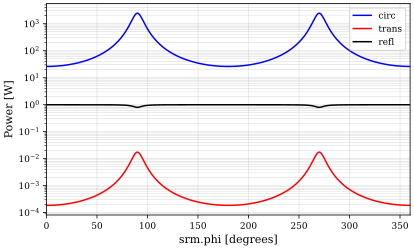

Power : 2462.78 W at srm.phi=90.000036 deg


In [13]:
Lsrc = 15.7562 + 15.4435 + 19.3660  # = 50.5657 m from https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html

ifo_srm = finesse.Model()
ifo_srm.parse(f"""
l l1 P=1
s s1 l1.p1 srm.p1

m srm T=0.324 L=0
s ssrc srm.p2 m1.p1 L={Lsrc}

m m1 T=0.0148 L=37.5e-6
s s2 m1.p2 m2.p1 L=3994.485
m m2 T=7.1e-6 L=37.5e-6

pd circ m1.p2.i
pd trans m2.p2.o
pd refl srm.p1.o
""")

out_srm = ifo_srm.run(Xaxis("srm.phi", "lin", 0, 360, 400))
out_srm.plot(logy=True)


sol = ifo_srm.run(Maximize(ifo_srm.circ, # "circulating power" detector
        parameter=ifo_srm.srm.phi,        # parameter to optimize 
        method="Nelder-Mead",
        fatol=1e-4,
        adaptive=True,
    )
)

print(f"Power : {-sol.result.fun:.6g} W at srm.phi={sol.result.x[0]:.6f} deg")


**Task**: Use the concept of a cavity as a composite mirror to explain the results above. What is the reflectivity and transmission of the composite mirror formed by the recycling mirror and the ITM in both cases. Can you measure it with FINESSE?

## Suggestions and other comments

1. These notebooks act as your “experiments.” Feel free to play around with different detectors, components, and different cavity geometries. 

2. Please use the FINESSE documentation page to search for anything that you might be interested in reading about and applying to this notebook (https://finesse.ifosim.org/docs/latest/index.html). 

3. Try copying and pasting these models into different cells and let your imagination/curiosity run wild. Try changing the parameters of your model and understand the consequences of it by plotting different detectors. The main gist of this exercise is to develop an understanding of the concepts and to be able to explain the plots and the results that you see.